## PD-управление

Дополните код, приведенный ниже.

- Реализуйте функцию, вычисляющую стоимость траектории. На вход ей поступает лист координат от времени, лист скоростей от времени, лист сил от времени и dt. На выход она отдает стоимость траектории.  
Стоимость всего квадратична: находиться в $m$ метрах от начала координат в течение одной секунды стоит $3 m^2$ попугаев, двигаться со скоростью $v$ метров в секунду в течении одной секунды стоит $5 v^2$ попугаев, прикладывать силу в $n$ ньютонов в течение одной текунды стоит $8 n^2$ попугаев.

- Попробуйте минимизировать стоимость траектории, варьируя $K_p$ и $K_d$.

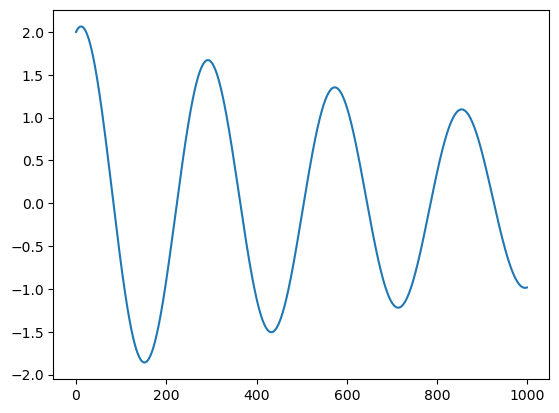

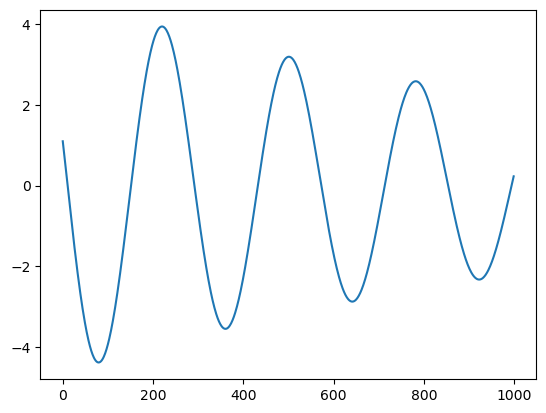

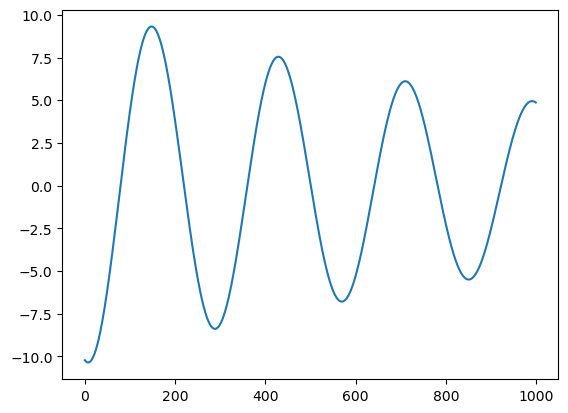

In [1]:
import matplotlib.pyplot as plt
import numpy as np

p = 2.0
p_dot = 1.1
dt = 0.01
m = 1

num_iter = 1000

p_hist = []
p_dot_hist = []
F_hist = []

K_p = 5
K_d = 0.2

for i in range(num_iter):
    p_hist.append(p)
    p_dot_hist.append(p_dot)
    
    #controller
    F = - K_p * p - K_d * p_dot
    F_hist.append(F)
    
    p += dt * p_dot
    p_dot += dt * F

plt.plot(p_hist)
plt.show()
plt.plot(p_dot_hist)
plt.show()
plt.plot(F_hist)
plt.show()

In [2]:
import jax
from jax.example_libraries import optimizers
import jax.numpy as jnp
from jax import grad
from functools import partial

In [3]:
# @jax.jit
def get_cost(p_hist, p_dot_hist, F_hist, dt):
    '''
    Assuming cost is constant for time dt get overall cost of trajectory
    '''

    p_cost = jnp.sum(3 * p_hist ** 2 * dt)
    p_dot_cost = jnp.sum(5 * p_dot_hist ** 2 * dt)
    F_cost = jnp.sum(8 * F_hist ** 2 * dt)

    return p_cost + p_dot_cost + F_cost

# get_cost_jax = jax.make_jaxpr(get_cost)

In [4]:
from functools import partial
# @partial(jax.jit, static_argnames=['num_iter'])
def get_hist(p, p_dot, dt, m, num_iter, K_p, K_d):

    p_hist = jnp.zeros(num_iter)
    p_dot_hist = jnp.zeros(num_iter)
    F_hist = jnp.zeros(num_iter)

    for i in range(num_iter):
        p_hist = p_hist.at[i].set(p)
        p_dot_hist = p_dot_hist.at[i].set(p_dot)
        
        #controller
        F = - K_p * p - K_d * p_dot
        F_hist = F_hist.at[i].set(F)
        
        p += dt * p_dot
        p_dot += dt * F

    return p_hist, p_dot_hist, F_hist

# get_hist_jax = jax.make_jaxpr(get_hist)

In [5]:
# @jax.jit
def run_exp(params):
    p_hist, p_dot_hist, F_hist = get_hist(
        p=2, p_dot=1.1, dt=0.01, 
        m=1, num_iter=1000, 
        K_p=params['K_p'], K_d=params['K_d']
    )

    cost = get_cost(p_hist, p_dot_hist, F_hist, dt=0.01)

    return cost

In [6]:
params_hist = []

grad_f = jax.grad(run_exp)

init_fn, update_fn, get_params = optimizers.adam(1e-1)
params = {'K_p': jnp.array(5.), 'K_d': jnp.array(0.2)}
opt_state = init_fn(params)

for i in range(100):
    params = get_params(opt_state)
    grad_value = grad_f(params)
    opt_state = update_fn(i, grad_value, opt_state)

    params_hist.append(params)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


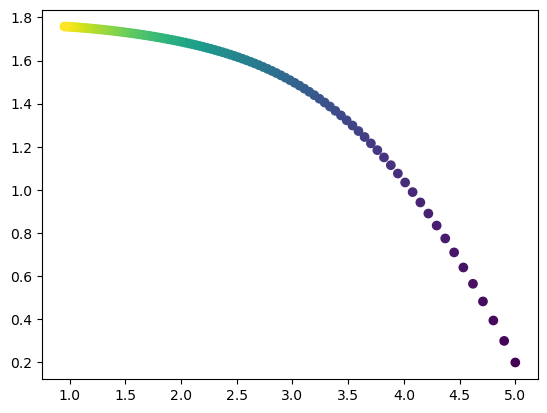

In [15]:
K_p_hist = [p['K_p'] for p in params_hist]
K_d_hist = [p['K_d'] for p in params_hist]
time = np.linspace(0, 1, len(params_hist))

plt.scatter(K_p_hist, K_d_hist, c=time)
plt.show()

In [16]:
print('Almost optimal params', params)

Almost optimal params {'K_d': Array(1.7577705, dtype=float32), 'K_p': Array(0.95237774, dtype=float32)}


### Симуляция динамических систем

Ниже даны заготовки для симуляции двух систем: линеаризованного маятника и линеаризованной системы из двух маятников, связанных пружиной.

Задачи:
- изучите код, поймите, как он работает
- заполните матрицу A для маятника, запустите код. Попробуйте поменять параметры системы и начальные условия, посмотрите, что меняется
- заполните матрицу A для системы из двух маятников. Попробуйте поменять жесткость пружины. Соответствует ли полученное физической интуиции?

P.S. рисование уже написано. Для того, чтобы оно заработало, нужно поставить библиотеку OpenCV. Сделать это (на Unix установленным pip) можно, выполнив следующую клетку. Выполнять ее каждый раз не нужно.

In [17]:
!pip install opencv-python

In [18]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact
from IPython.display import display, clear_output

def plot_1d(data):
    plt.figure(figsize=(15, 4))
    plt.plot(data)
    plt.show()

QObject::moveToThread: Current thread (0x1e12b9a0) is not the object's thread (0x27c1bff0).
Cannot move to target thread (0x1e12b9a0)

QObject::moveToThread: Current thread (0x1e12b9a0) is not the object's thread (0x27c1bff0).
Cannot move to target thread (0x1e12b9a0)

QObject::moveToThread: Current thread (0x1e12b9a0) is not the object's thread (0x27c1bff0).
Cannot move to target thread (0x1e12b9a0)

QObject::moveToThread: Current thread (0x1e12b9a0) is not the object's thread (0x27c1bff0).
Cannot move to target thread (0x1e12b9a0)

QObject::moveToThread: Current thread (0x1e12b9a0) is not the object's thread (0x27c1bff0).
Cannot move to target thread (0x1e12b9a0)

QObject::moveToThread: Current thread (0x1e12b9a0) is not the object's thread (0x27c1bff0).
Cannot move to target thread (0x1e12b9a0)

QObject::moveToThread: Current thread (0x1e12b9a0) is not the object's thread (0x27c1bff0).
Cannot move to target thread (0x1e12b9a0)

QObject::moveToThread: Current thread (0x1e12b9a0) is n

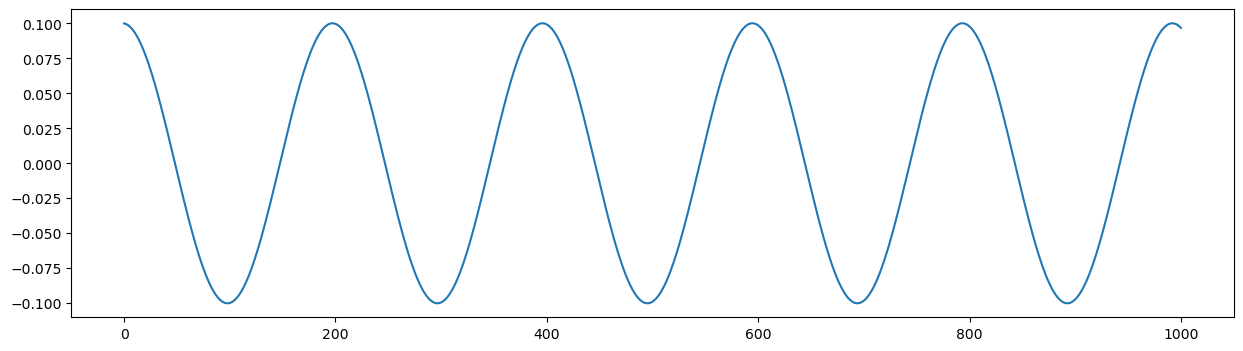

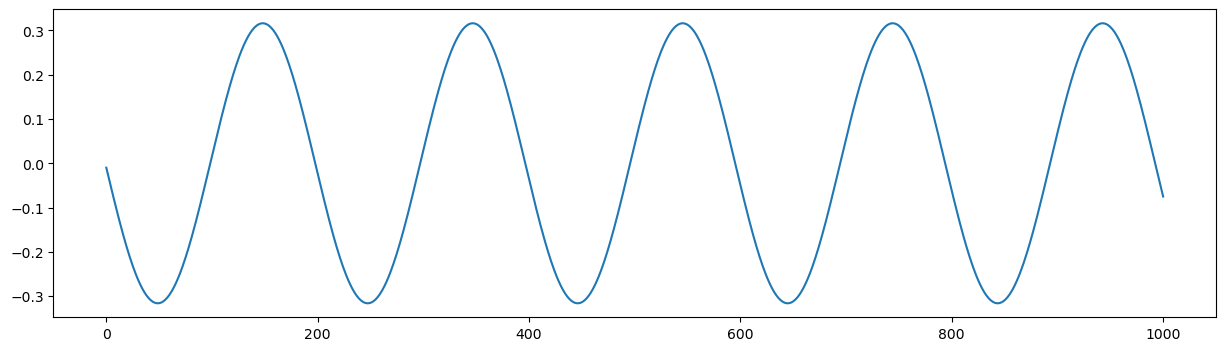

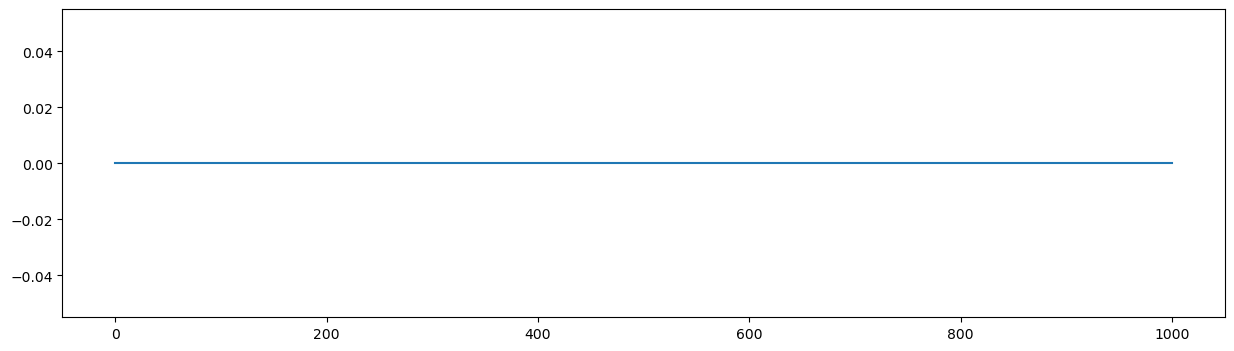

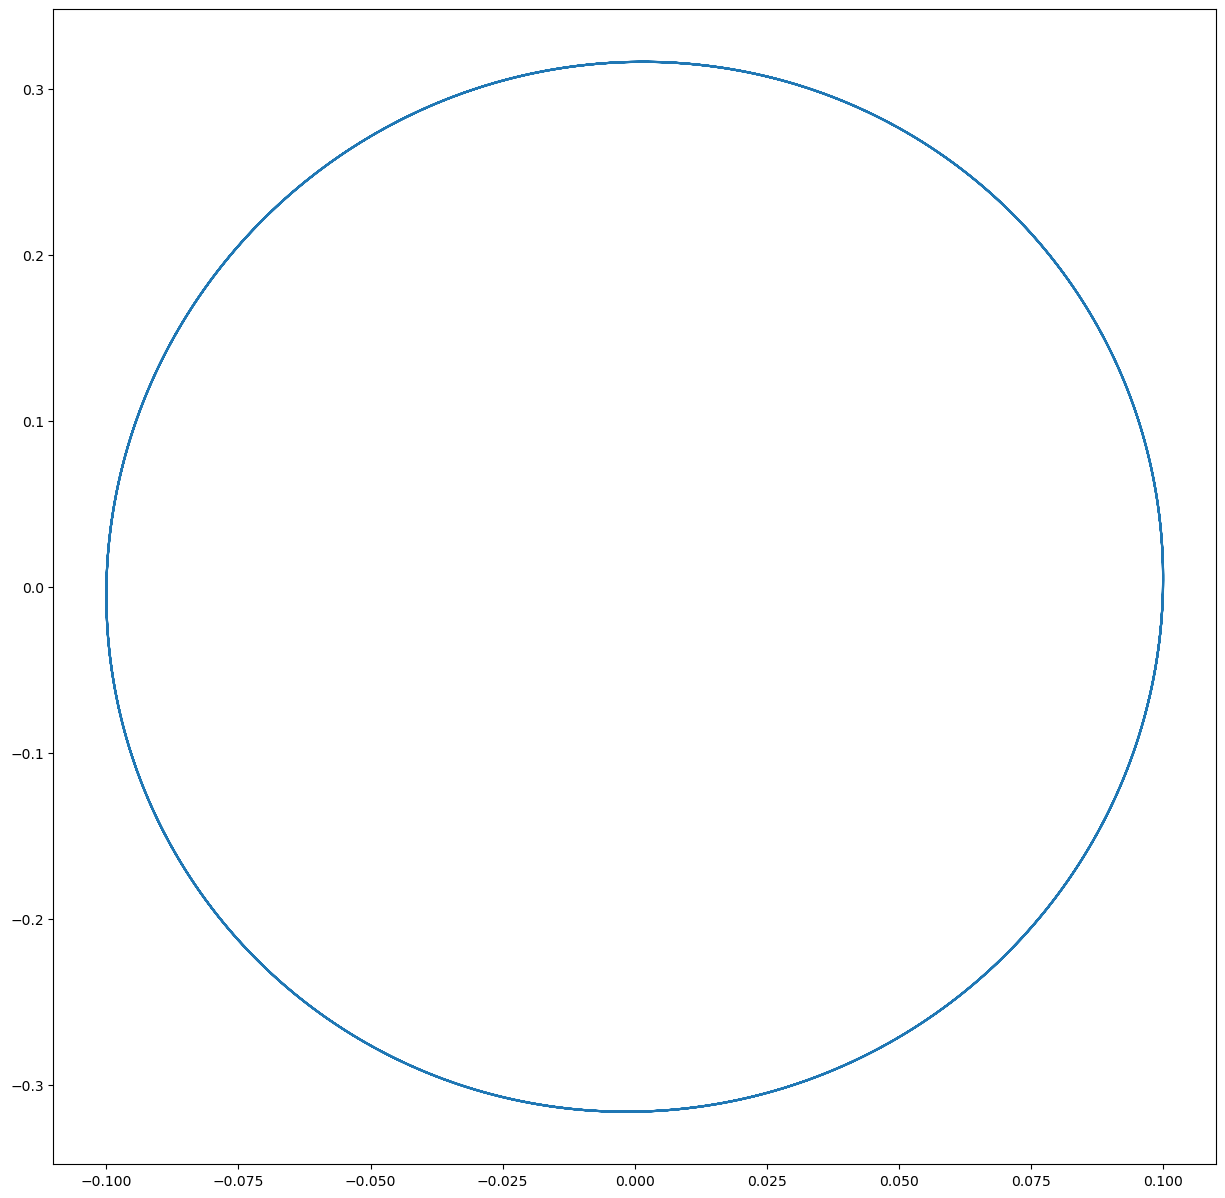

In [19]:
class Linearized_pendulum:
    def __init__(self, m = 1.0, l = 1.0, g = 10.0, x0 = 3, v0 = 0.0, dt = 0.01):
        self.m = m
        self.l = l
        self.g = g
        
        self.x = np.array([[x0], [v0]])
        self.dt = dt
        
        #state transition
        
        #YOUR CODE BELOW
        self.A = np.array([[0. , 1.],
                           [-g / l, 0.]])
        
        #control -> xdot (matrix B from x_dot = Ax + Bu)
        self.B = np.array([[0], [0]])
        
        #YOUR CODE ABOVE
        
    def get_state(self):
        return self.x
    
    def sys_dyn(self, u_scalar):
        x_dot = np.zeros_like(self.x)
        
        u = np.array([[u_scalar]])
        x_dot = self.A @ self.x + self.B @ u
        
        return x_dot
    
    def integrate_sys_dyn(self, sys_dyn):        
        self.x[1] += sys_dyn[1] * self.dt
        self.x[0] += self.x[1] * self.dt

def draw_pendulum(canvas, x, y, l, alpha, color = (123, 234, 234),
                  inverted = False):
    direction = -1
    
    if (inverted == True):
        direction = 1
    
    endpoint = (int(x - l * np.cos(alpha + direction * np.pi / 2)),
                int(y + l * np.sin(alpha + direction * np.pi / 2)))
    
    cv2.line(canvas, (x, y), endpoint, (123, 234, 234), 5)
    
    cv2.circle(canvas, endpoint, 25, color, -1)

def run_pendulum(x0, iter_num, visualize):
    if (visualize == True):
        WIND_X = 700
        WIND_Y = 700
        canvas = np.ones((700, 700, 3), np.uint8) * 70
    
    pendulum = Linearized_pendulum(x0 = x0)

    i = 0

    x_traj = []
    v_traj = []
    u_traj = []
    
    while(True):
        state = pendulum.get_state()

        control = 0
        
        x_dot = pendulum.sys_dyn(control)
                
        pendulum.integrate_sys_dyn(x_dot)
        
        x_traj.append(state[0, 0])
        v_traj.append(state[1, 0])
        u_traj.append(control)
        
        i += 1

        if (i > iter_num):
            break

        if (visualize == True):
            canvas = cv2.addWeighted(canvas, 0.93, canvas, 0, 0)

            draw_pendulum(canvas, WIND_X // 2, WIND_Y // 2, 300,
                          state[0, 0], (123, 234, 45), inverted = True)

            cv2.imshow("pendulum", canvas)

            key = cv2.waitKey(10) & 0xFF

            if (key == ord('q')):
                break
    
    if (visualize == True):
        cv2.destroyAllWindows()
        cv2.waitKey(10)
    
    return x_traj, v_traj, u_traj

x_hist, v_hist, u_hist = run_pendulum(x0 = 0.1, iter_num = 1000, visualize = True)

plot_1d(x_hist)
plot_1d(v_hist)
plot_1d(u_hist)

plt.figure(figsize=(15, 15))
plt.plot(x_hist, v_hist)
plt.show()
clear_output(wait = True)

QObject::moveToThread: Current thread (0x1e12b9a0) is not the object's thread (0x27c1bff0).
Cannot move to target thread (0x1e12b9a0)

QObject::moveToThread: Current thread (0x1e12b9a0) is not the object's thread (0x27c1bff0).
Cannot move to target thread (0x1e12b9a0)

QObject::moveToThread: Current thread (0x1e12b9a0) is not the object's thread (0x27c1bff0).
Cannot move to target thread (0x1e12b9a0)

QObject::moveToThread: Current thread (0x1e12b9a0) is not the object's thread (0x27c1bff0).
Cannot move to target thread (0x1e12b9a0)

QObject::moveToThread: Current thread (0x1e12b9a0) is not the object's thread (0x27c1bff0).
Cannot move to target thread (0x1e12b9a0)

QObject::moveToThread: Current thread (0x1e12b9a0) is not the object's thread (0x27c1bff0).
Cannot move to target thread (0x1e12b9a0)

QObject::moveToThread: Current thread (0x1e12b9a0) is not the object's thread (0x27c1bff0).
Cannot move to target thread (0x1e12b9a0)

QObject::moveToThread: Current thread (0x1e12b9a0) is n

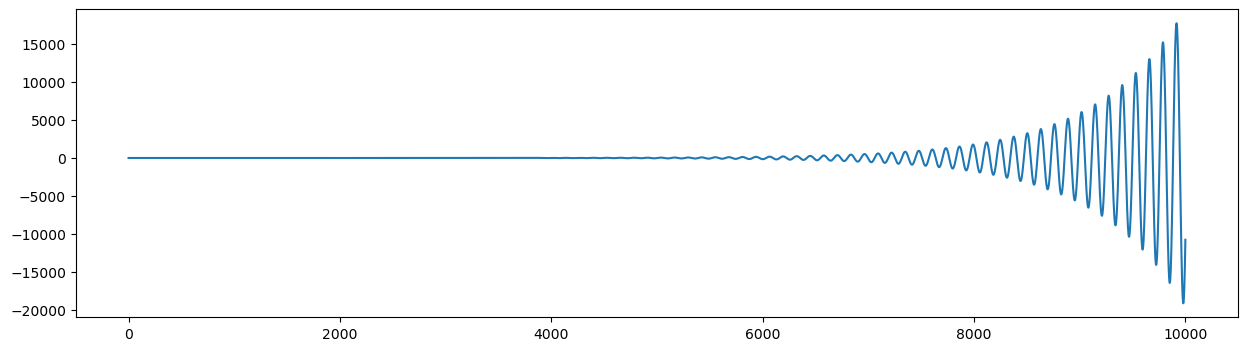

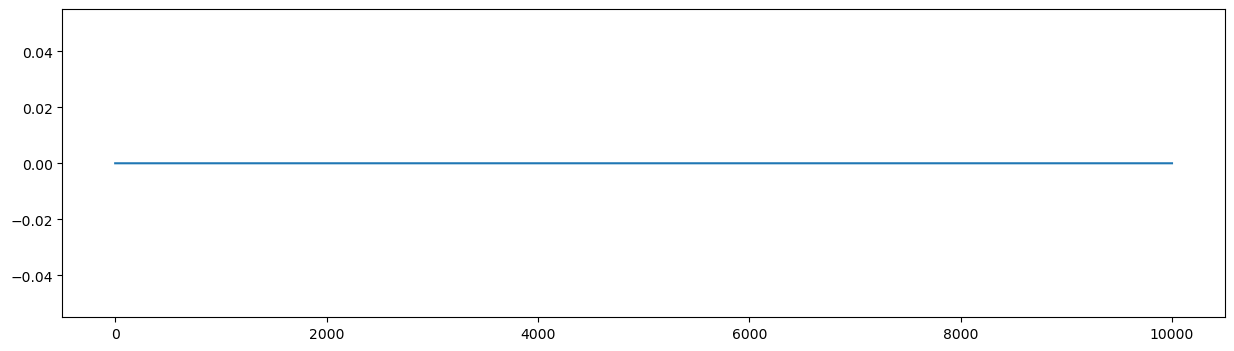

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from scipy import linalg

class Two_pend_one_spring:
    def __init__(self, m = 5.0, l = 1.0, k = 35.0, g = 10.0,
                 a0 = 0.0, ad0 = 0.0, b0 = 0.0, bd0 = 0.0,
                 dt = 0.01):
        self.m = m
        self.l = l
        self.k = k
        self.g = g
        
        self.x = np.array([[a0], [ad0], [b0], [bd0]])
        self.dt = dt
        
        #YOUR CODE BELOW
        
        #state transition function
        self.A = np.array\
        ([[0. , 1. , 0. , 0.],
          [(-k * l - m * g) / (m * l) , 0. , -k / m, 0.],
          [0. , 0. , 0. , 1.],
          [-k / m , 0. , (-k * l - m * g) / (m * l), 0.]])
        
        #control -> xdot (matrix B from x_dot = Ax + Bu)
        self.B = np.array([[0], [0], [0], [0]])
        
        #YOUR CODE ABOVE
        
    def get_state(self):
        return self.x
    
    def sys_dyn(self, u):
        x_dot = np.zeros_like(self.x)
        
        ax = self.A @ self.x
        bu = self.B * u
        
        x_dot = ax + bu
        
        return x_dot
    
    def integrate_sys_dyn(self, sys_dyn):
        self.x = self.x + sys_dyn * self.dt
    
def run_2_pend(a0 = 0.1, ad0 = 1.0, b0 = -0.1, bd0 = 0.2, iter_num = 10000, visualize = True):
    if (visualize == True):
        WIND_X = 700
        WIND_Y = 700
        canvas = np.ones((700, 700, 3), np.uint8) * 70
    
    dyn_point = Two_pend_one_spring(a0 = a0, ad0 = ad0, b0 = b0, bd0 = bd0)

    i = 0

    x_traj = []
    u_traj = []
    
    while(True):
        state = dyn_point.get_state()

        control = np.array([[0]])

        x_dot = dyn_point.sys_dyn(control)
        
        dyn_point.integrate_sys_dyn(x_dot)
        
        x_traj.append(state)
        u_traj.append(control)

        i += 1

        if (i > iter_num):
            break
            
        if (visualize == True):
            canvas = cv2.addWeighted(canvas, 0.93, canvas, 0, 0)

            draw_pendulum(canvas, WIND_X // 2 - 100, WIND_Y // 2, 300,
                          state[0, 0], (123, 234, 45), inverted = True)
            
            draw_pendulum(canvas, WIND_X // 2 + 100, WIND_Y // 2, 300,
                          state[2, 0], (123, 234, 45), inverted = True)

            cv2.imshow("pendulums", canvas)

            key = cv2.waitKey(10) & 0xFF

            if (key == ord('q')):
                break
    
    if (visualize == True):
        cv2.destroyAllWindows()
        cv2.waitKey(10)
    
    return x_traj, u_traj

def run_and_plot_2_pend():
    x_hist, u_hist = run_2_pend()
    
    x_list = [x[0, 0] for x in x_hist]
    plot_1d(x_list)
    
    u_hist_list = [el[0, 0] for el in u_hist]
    
    plot_1d(u_hist_list)
    
    return x_hist, u_hist

x_hist, u_hist = run_and_plot_2_pend()

# Выводы
Колебания не малые + накопление ошибки приводят к тому что система быстро становится не стабильной. 